<a href="https://colab.research.google.com/github/rizkybagas557/Machine-Learning/blob/main/Predictive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Langkah awal dari proyek ini adalah melakukan instalasi dan import library yang dibutuhkan. Library yang digunakan mencakup:

- **Pandas, NumPy**: Untuk manipulasi data.
- **Matplotlib, Seaborn**: Untuk visualisasi data dan evaluasi model.
- **Scikit-learn**: Untuk preprocessing, training, dan evaluasi model.
- **XGBoost**: Model boosting untuk klasifikasi.
- **Imbalanced-learn**: Untuk menangani masalah class imbalance dengan teknik seperti SMOTE.
- **Google Colab Drive & Files**: Untuk mengelola file dan menyimpan model ke Google Drive.
- **Joblib**: Untuk menyimpan dan memuat model machine learning.


In [18]:
# ========== INISIALISASI LIBRARY ==========
# Instalasi
!pip install -q kaggle xgboost scikit-learn imbalanced-learn matplotlib seaborn

# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive, files

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluasi
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix, roc_curve, roc_auc_score,
                            precision_recall_curve, PrecisionRecallDisplay)

# Save Model
import joblib

Untuk mengambil dataset dari Kaggle, diperlukan API Token berupa file `kaggle.json` yang bisa diunduh dari halaman akun Kaggle

Langkah-langkah:
1. Upload file `kaggle.json` ke Google Colab.
2. Set permission dan path ke folder `.kaggle`.
3. Gunakan perintah `kaggle datasets download` untuk mengunduh dataset.


In [19]:
# ========== SETUP KAGGLE ==========
# Upload kaggle.json
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# ========== LOAD DATA ==========
!kaggle datasets download -d uciml/pima-indians-diabetes-database
!unzip pima-indians-diabetes-database.zip
df = pd.read_csv('diabetes.csv')

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
License(s): CC0-1.0
pima-indians-diabetes-database.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  pima-indians-diabetes-database.zip
replace diabetes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


analisis data sangat penting untuk mengidentifikasi potensi data yang tidak valid, nilai ekstrem, atau kolom yang membutuhkan perlakuan khusus sebelum modeling.

In [20]:
# Load data
df = pd.read_csv('diabetes.csv')
print("Preview Data:")
print(df.head())

# Cek info dataset
print("\nInfo Dataset:")
print(df.info())

# Statistik deskriptif
print("\nStatistik Deskriptif:")
print(df.describe())

Preview Data:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   

Membersihkan dan menyiapkan data sebelum dimasukkan ke dalam model machine learning. Beberapa langkah penting dalam tahap ini adalah mengatasi *Missing Value*,*Bagi Data 70%:30%*,*Normalisasi*,dan atasi ketidakseimbagan data dengan **SMOTE**.

In [21]:
# ========== PREPROCESSING ==========
# Handle missing values
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_features] = df[zero_features].replace(0, np.nan)
df.fillna(df.median(), inplace=True)

# Split data
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

Algoritma yang Digunakan:
- **Logistic Regression**: Model linear baseline yang sering digunakan dalam klasifikasi biner.
- **Random Forest**: Model berbasis ensemble yang kuat terhadap overfitting dan mampu menangani fitur non-linear.
- **XGBoost**: Model boosting populer yang dikenal sangat akurat dan efisien pada data tabular.

In [22]:
# ========== MODELING ==========
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(learning_rate=0.1, max_depth=3)
}

results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1]

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_proba),
        'cm': confusion_matrix(y_test, y_pred),
        'fpr': roc_curve(y_test, y_proba)[0],
        'tpr': roc_curve(y_test, y_proba)[1],
        'precision': precision_recall_curve(y_test, y_proba)[0],
        'recall': precision_recall_curve(y_test, y_proba)[1],
    }

In [23]:
# ========== PERBANDINGAN MODEL ==========
print("\n\n=== PERBANDINGAN KOMPREHENSIF MODEL ===")

# 1. Tabel Metrik Utama
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results],
    'AUC-ROC': [results[name]['auc'] for name in results],
    'Precision (1)': [results[name]['precision'][1] for name in results],  # Precision untuk kelas diabetes
    'Recall (1)': [results[name]['recall'][1] for name in results]       # Recall untuk kelas diabetes
}).sort_values('AUC-ROC', ascending=False)

print("\nTabel Perbandingan Metrik:")
display(metrics_df.style.background_gradient(cmap='Blues', subset=['Accuracy', 'AUC-ROC']))



=== PERBANDINGAN KOMPREHENSIF MODEL ===

Tabel Perbandingan Metrik:


,Model,Accuracy,AUC-ROC,Precision (1),Recall (1)
1,Random Forest,0.753247,0.805298,0.349345,1.000000
2,XGBoost,0.718615,0.800331,0.347826,1.000000
0,Logistic Regression,0.701299,0.799917,0.347826,1.000000


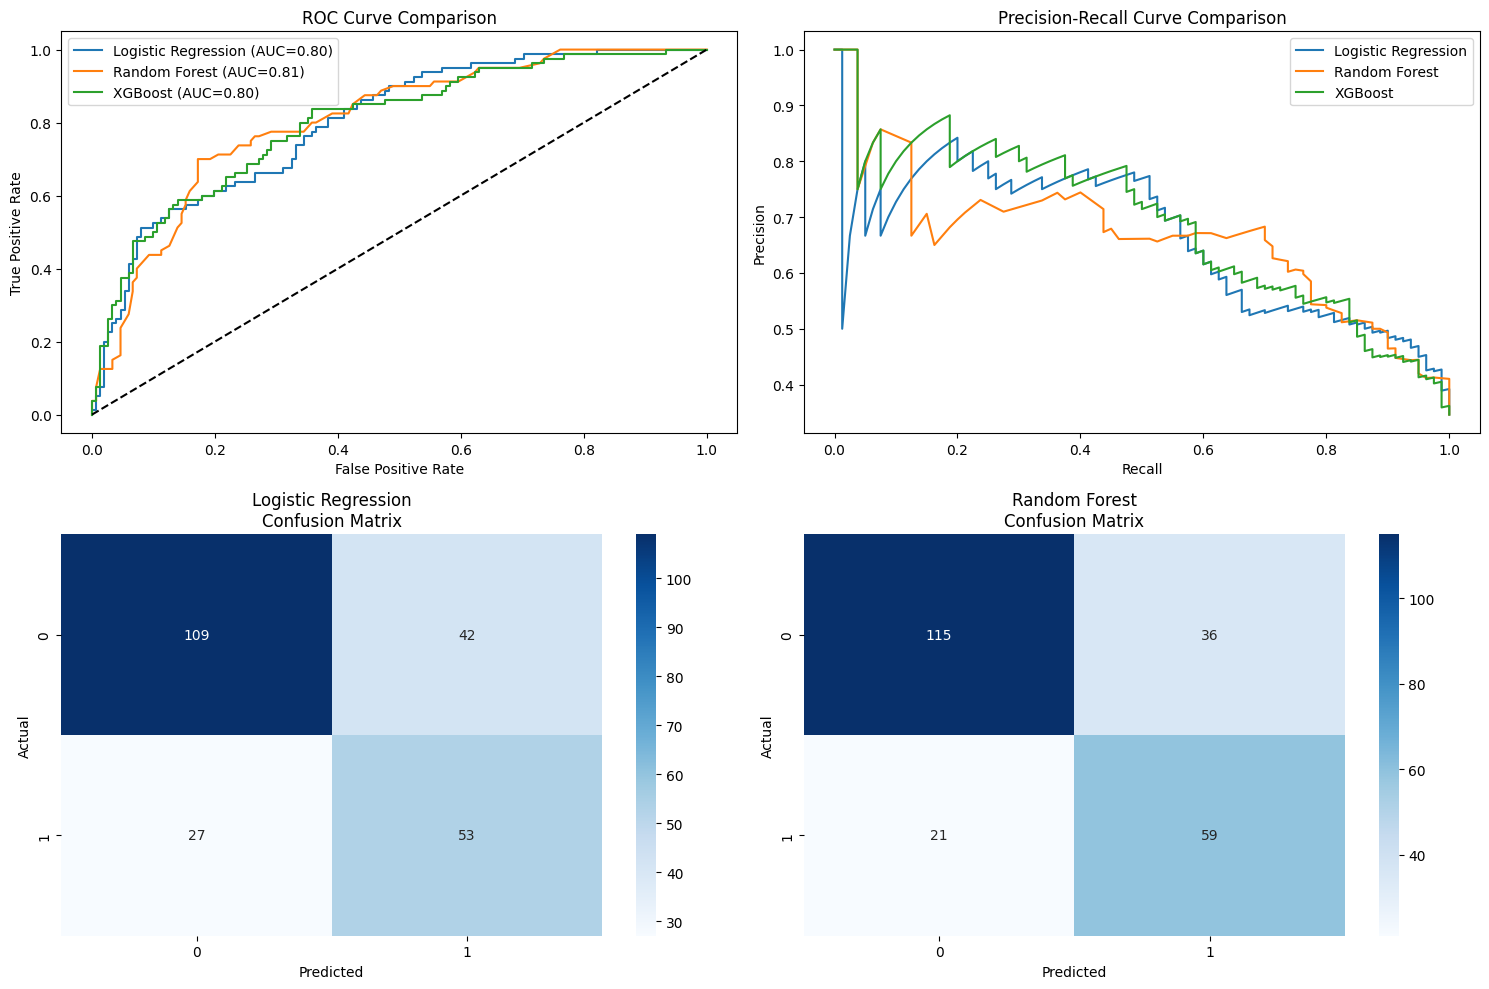

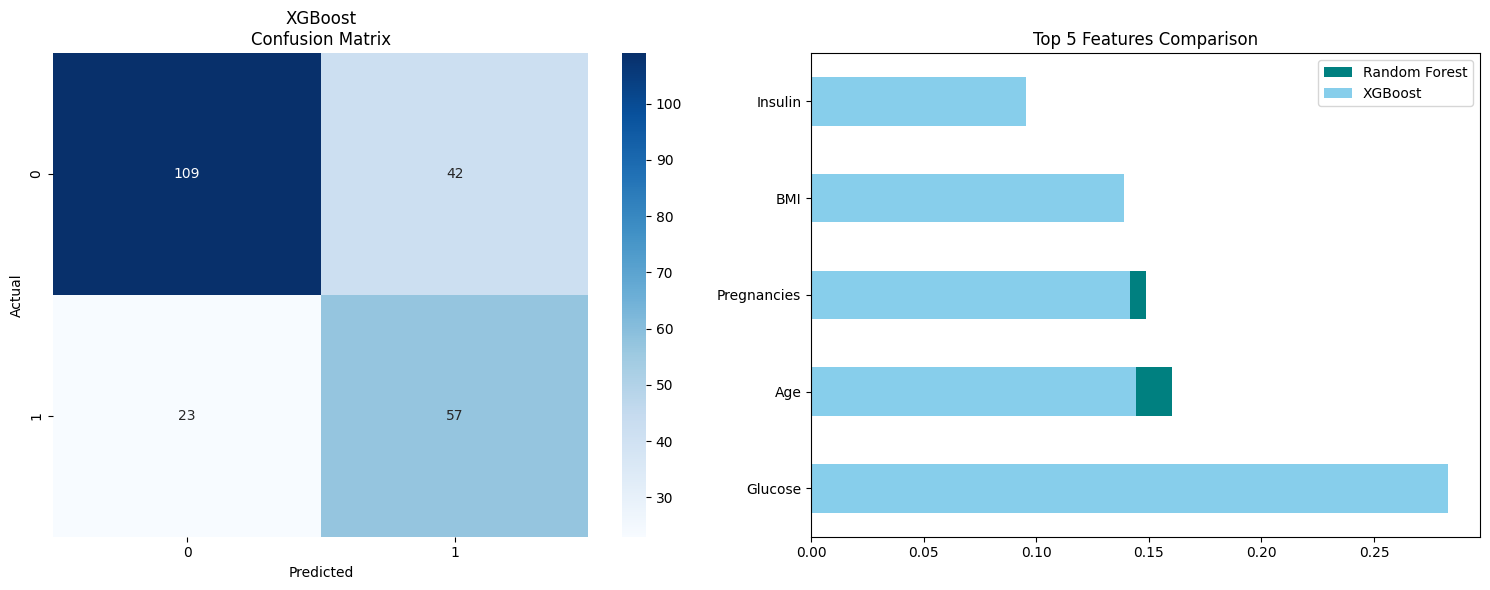

In [24]:
# ========== VISUALISASI ==========
plt.figure(figsize=(15, 10))

# ROC Curve Comparison
plt.subplot(2, 2, 1)  # Posisi 1
for name in models.keys():
    plt.plot(results[name]['fpr'], results[name]['tpr'],
             label=f'{name} (AUC={results[name]["auc"]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()

# Precision-Recall Curve
plt.subplot(2, 2, 2)  # Posisi 2
for name in models.keys():
    plt.plot(results[name]['recall'], results[name]['precision'],
             label=name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()

# Confusion Matrix - Logistic Regression
plt.subplot(2, 2, 3)  # Posisi 3
sns.heatmap(results['Logistic Regression']['cm'], annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Confusion Matrix - Random Forest
plt.subplot(2, 2, 4)  # Posisi 4
sns.heatmap(results['Random Forest']['cm'], annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Buat figure baru untuk XGBoost dan Feature Importance
plt.figure(figsize=(15, 6))

# Confusion Matrix - XGBoost
plt.subplot(1, 2, 1)
sns.heatmap(results['XGBoost']['cm'], annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Feature Importance
plt.subplot(1, 2, 2)
for i, name in enumerate(['Random Forest', 'XGBoost']):
    if name == 'Random Forest':
        feat_imp = pd.Series(models[name].feature_importances_, index=X.columns)
    else:
        feat_imp = pd.Series(models[name].feature_importances_, index=X.columns)
    feat_imp.nlargest(5).plot(kind='barh', color=['teal', 'skyblue'][i])
plt.title('Top 5 Features Comparison')
plt.legend(['Random Forest', 'XGBoost'])
plt.tight_layout()
plt.show()

ROC (Receiver Operating Characteristic) curve menggambarkan hubungan antara True Positive Rate (Recall) dan False Positive Rate pada berbagai threshold klasifikasi.
AUC (Area Under Curve) digunakan untuk mengukur performa model secara keseluruhan.

Interpretasi:

Logistic Regression: AUC = 0.80

Random Forest: AUC = 0.81

XGBoost: AUC = 0.80

Precision-Recall curve menunjukkan trade-off antara Precision (akurasi prediksi positif) dan Recall (kemampuan mendeteksi kasus positif).
Semua model mengalami penurunan precision saat recall mendekati 1, artinya semakin banyak prediksi positif yang dibuat, semakin tinggi kemungkinan false positives.Logistic Regression menghasilkan cukup banyak false positives, yang menjelaskan mengapa precision-nya rendah walaupun recall sangat tinggi.

In [25]:
drive.mount('/content/drive')
best_model = XGBClassifier(learning_rate=0.1, max_depth=3)
best_model.fit(X_train_res, y_train_res)
joblib.dump(best_model, '/content/drive/MyDrive/diabetes_model.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/scaler.pkl')
print("Model berhasil disimpan!")

Mounted at /content/drive
Model berhasil disimpan!


In [26]:
# ========== CONTOH PREDIKSI ==========
new_data = [[2, 150, 70, 30, 100, 25.5, 0.42, 35]]
new_scaled = scaler.transform(new_data)
prediction = best_model.predict(new_scaled)
probability = best_model.predict_proba(new_scaled)[0][1]
print(f"\nPrediksi: {'Diabetes' if prediction[0]==1 else 'Tidak Diabetes'}")
print(f"Probabilitas: {probability*100:.2f}%")


Prediksi: Diabetes
Probabilitas: 62.82%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
